# GEM ML Framework Demonstrator - Water Segmentation
In these notebooks, we will get a feeling of how the GEM ML framework can be used for the segmentation of water bodies using Sentinel-1 imagery as input and Sentinel-2 based normalised difference water index (NDWI) as a reference.
The idea is to use a neural network (NN) model for the analysis.
Thanks to the flexibility of the GEM ML framework, the model used can be replaced by changing the configuration only.
We will have a look at the following notebooks separately:
- 00_Configuration
- 01_DataAcquisition
- 02_DataNormalisation
- 03_TrainingValidationTesting
- 04_DecisionMaking

by Michael Engel (m.engel@tum.de)

-----------------------------------------------------------------------------------

# Training, Validation and Testing
In this notebook, we will train, validate and test the model of choice.

In [1]:
import os
import sys
import platform
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
import natsort

import torch
import torch.multiprocessing as mp
from tensorboardX import SummaryWriter
from tensorboard import notebook

from sentinelhub import SHConfig, BBox, CRS, DataCollection, UtmZoneSplitter, DataCollection
from eolearn.core import FeatureType, EOPatch, MergeEOPatchesTask, MapFeatureTask, MergeFeatureTask, ZipFeatureTask, LoadTask, EONode, EOWorkflow, EOExecutor, OverwritePermission, SaveTask
from eolearn.io import SentinelHubDemTask, ExportToTiffTask, SentinelHubInputTask, SentinelHubEvalscriptTask, get_available_timestamps
from eolearn.mask import CloudMaskTask, JoinMasksTask

import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,Point
import folium
from folium import plugins as foliumplugins

from libs.ConfigME import Config, importME
from libs.MergeTDigests import mergeTDigests
from libs.QuantileScaler_eolearn import QuantileScaler_eolearn_tdigest
from libs.Dataset_eolearn import Dataset_eolearn
from libs import AugmentME
from libs import ExecuteME

from tasks.TDigestTask import TDigestTask
from tasks.PickIdxTask import PickIdxTask
from tasks.SaveValidTask import SaveValidTask
from tasks.PyTorchTasks import ModelForwardTask

from utils.rasterio_reproject import rasterio_reproject
from utils.transforms import batchify, predict, mover, Torchify
from utils.parse_time_interval_observations import parse_time_interval_observations

print("Working Directory:",os.getcwd())
print("Environment:",os.environ['CONDA_DEFAULT_ENV'])
print("Executable:",sys.executable)

C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Incorporating libs!
Incorporating tasks!
Incorporating utils!
Working Directory: D:\OneDrive\Offiziell\Promotion\Code\Git\eo-learn-examples\GEM-ML\Example_WaterSegmentation
Environment: eolearn_water
Executable: C:\Users\skryp\miniconda3\envs\eolearn_water\python.exe


# Config
First, we load our configuration file which provides all information we need throughout the script.

In [2]:
#%% load configuration file
config = Config.LOAD("config.dill")

# Quantile Scaling
As discussed in the second notebook, we want to apply quantile scaling to our data.
We load the scaler, we already defined.

In [3]:
Scaler = QuantileScaler_eolearn_tdigest.LOAD(os.path.join(config["dir_results"],config["savename_scaler"]))

# Dataoader
First, we need to get the paths for all samples within our training, validation and testing datasets, respectively.

In [4]:
#%% training samples
paths_train = [os.path.join(config["dir_train"],file).replace("\\","/") for file in os.listdir(config["dir_train"])]

#%% validation samples
paths_validation = [os.path.join(config["dir_validation"],file).replace("\\","/") for file in os.listdir(config["dir_validation"])]

#%% testing samples
paths_test = [os.path.join(config["dir_test"],file).replace("\\","/") for file in os.listdir(config["dir_test"])]

Now, we are ready to define our datasets using the `Dataset_eolearn`!
Remember that PyTorch asks for the shape `[batch_size x channels x timestamps x height x width]`.
The `QuantileScaler_eolearn_tdigest` handles this by setting `transform=Torchify(1)`.
For the reference and the mask, we use the `Torchify` class as provided from the `Dataset_eolearn` package, too.

In [5]:
#%% training dataset
dataset_train = Dataset_eolearn(
    paths = paths_train,
    feature_data = (FeatureType.DATA,"data"),
    feature_reference = (FeatureType.MASK_TIMELESS,"reference"),
    feature_mask = (FeatureType.MASK_TIMELESS,"mask_reference"),

    transform_data = Scaler,
    transform_reference = Torchify(1),
    transform_mask = Torchify(1),
    
    return_idx = True,
    return_path = False,

    torchdevice = None,
    torchtype_data = torch.FloatTensor,
    torchtype_reference = torch.LongTensor,
    torchtype_mask = torch.LongTensor,
)

#%% validation dataset
dataset_validation = Dataset_eolearn(
    paths = paths_validation,
    feature_data = (FeatureType.DATA,"data"),
    feature_reference = (FeatureType.MASK_TIMELESS,"reference"),
    feature_mask = (FeatureType.MASK_TIMELESS,"mask_reference"),

    transform_data = Scaler,
    transform_reference = Torchify(1),
    transform_mask = Torchify(1),
    
    return_idx = True,
    return_path = False,

    torchdevice = None,
    torchtype_data = torch.FloatTensor,
    torchtype_reference = torch.LongTensor,
    torchtype_mask = torch.LongTensor,
)

#%% testing dataset
dataset_test = Dataset_eolearn(
    paths = paths_test,
    feature_data = (FeatureType.DATA,"data"),
    feature_reference = (FeatureType.MASK_TIMELESS,"reference"),
    feature_mask = (FeatureType.MASK_TIMELESS,"mask_reference"),

    transform_data = Scaler,
    transform_reference = Torchify(1),
    transform_mask = Torchify(1),
    
    return_idx = True,
    return_path = False,

    torchdevice = None,
    torchtype_data = torch.FloatTensor,
    torchtype_reference = torch.LongTensor,
    torchtype_mask = torch.LongTensor,
)

Let's test our datasets!

In [6]:
sample_train = dataset_train[:config["batch_size"]]
print('Training Data Shape:',sample_train[0].shape)
print('Training Reference Shape:',sample_train[1].shape)
print('Training Mask Shape:',sample_train[2].shape)
print()

sample_validation = dataset_validation[:config["batch_size"]]
print('Validation Data Shape:',sample_validation[0].shape)
print('Validation Reference Shape:',sample_validation[1].shape)
print('Validation Mask Shape:',sample_validation[2].shape)
print()

sample_test = dataset_test[:config["batch_size"]]
print('Testing Data Shape:',sample_test[0].shape)
print('Testing Reference Shape:',sample_test[1].shape)
print('Testing Mask Shape:',sample_test[2].shape)
print()

Training Data Shape: torch.Size([16, 2, 256, 256])
Training Reference Shape: torch.Size([16, 256, 256])
Training Mask Shape: torch.Size([16, 256, 256])

Validation Data Shape: torch.Size([16, 2, 256, 256])
Validation Reference Shape: torch.Size([16, 256, 256])
Validation Mask Shape: torch.Size([16, 256, 256])

Testing Data Shape: torch.Size([16, 2, 256, 256])
Testing Reference Shape: torch.Size([16, 256, 256])
Testing Mask Shape: torch.Size([16, 256, 256])



Let's define our dataloader for each dataset.
We will double our `batch_size` for validation and testing as no gradient calculation is needed here.

In [7]:
#%% training dataloader
dataloader_train = torch.utils.data.DataLoader(
    dataset = dataset_train,
    batch_size = config["batch_size"],
    shuffle = True,
    sampler = None,
    batch_sampler = None,
    num_workers = 0 if platform.system()=="Windows" else config["threads"],
    collate_fn = None,
    pin_memory = False,
    drop_last = True,
    timeout = 0,
    worker_init_fn = None,
    multiprocessing_context = None,
    generator = None
)

#%% validation dataloader
dataloader_validation = torch.utils.data.DataLoader(
    dataset = dataset_validation,
    batch_size = config["max_batch_size"]*2,
    shuffle = False,
    sampler = None,
    batch_sampler = None,
    num_workers = 0 if platform.system()=="Windows" else config["threads"],
    collate_fn = None,
    pin_memory = False,
    drop_last = True,
    timeout = 0,
    worker_init_fn = None,
    multiprocessing_context = None,
    generator = None
)

#%% testing dataloader
dataloader_test = torch.utils.data.DataLoader(
    dataset = dataset_test,
    batch_size = config["max_batch_size"]*2,
    shuffle = False,
    sampler = None,
    batch_sampler = None,
    num_workers = 0 if platform.system()=="Windows" else config["threads"],
    collate_fn = None,
    pin_memory = False,
    drop_last = True,
    timeout = 0,
    worker_init_fn = None,
    multiprocessing_context = None,
    generator = None
)

# Model
Now, it's time to initialise our model.
We will do that using `importME` since we want to keep flexibility with regard to the model architecture used.

In [8]:
#%% import model
module_model = importME(config["module_model"])

#%% initialise model
model = module_model(**config["kwargs_model"])

Now, we want to augment the model such that it fits in our training pipeline.
We will add some IO methods such as saving and loading to it.
Further, we will add a method for getting the gradients during training.
That will be used for a brainwave monitor.
The benefit of that gets clear if you think of changing the architecture used but do not mean to change the IO interface of your code.

In [9]:
#%% general IO
AugmentME.augment_IO(model,savekey='save',loadkey='load',mode='torch')

#%% checkpoint saving
AugmentME.augment_checkpoint(model,key='save_checkpoint',mode='torch')

#%% gradient method
AugmentME.augment_gradient(model,key='get_gradient',mode=None)

#%% number of parameters
AugmentME.augment_Ntheta(model,key="get_Ntheta")

True

As a test if the augmenting worked, we want to have a look at the number of parameters.

In [10]:
#%% number of parameters
print("Number of parameters:",model.get_Ntheta())

Number of parameters: 22434578


# Training
Before we can start training our model, we have to define a loss function.
We will keep it as flexible as the model itself and use `importME`.

In [11]:
loss_function = importME(config["module_loss"])(**config["kwargs_loss"])

No optimization without an optimizer! 
Due to corresponding device issues, we have to send our model to the device before we define our optimizer.

In [12]:
#%% send model to device to avoid device errors
model.to(config["device"])

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

Now, we can define our optimizer with the parameters already been sent to our chosen device!

In [13]:
optimizer = importME(config["module_optimizer"])(model.parameters(),**config["kwargs_optimizer"])

To assess the performance of our model, we load some metric.

In [14]:
metric = importME(config["module_metric"])

Of course, we would like to track the proceeding of our training procedure.
Hence, we define a tensorboard [SummaryWriter](https://tensorboardx.readthedocs.io/en/latest/tensorboard.html#tensorboardX.SummaryWriter).

In [15]:
writer = SummaryWriter(config["dir_tensorboard"])

The tensorboard SummaryWriter enables us to do some nice stuff.
For example, we may add some graph of our model.

In [16]:
writer.add_graph(model, sample_train[0].to(config["device"]))

C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\segmentation_models_pytorch\base\model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


Anyway, we would like to make our experiment reproducible.
Thus, we set the seeds such that all random number generation and shuffling is done in a deterministic manner.

In [17]:
#%% reproducibility
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In case of a premature exit of the training procedure, we insert a resume flag here.
It enables the user to start with the chosen checkpoint or automatically choose the most recent one.

In [18]:
#%% resume flag
resume = False

#%% resume case
if resume:
    if resume==True:
        resume = os.path.join(config["dir_checkpoints"],natsort.natsorted(os.listdir(config["dir_checkpoints"]))[-1])
    else:
        resume = resume
    
    print(f'Loading Checkpoint {resume}!')
    checkpoint = torch.load(resume,map_location=config["device"])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    bestloss = checkpoint['bestloss']
    epoch_ = checkpoint['epoch']+1
    logstep_ = checkpoint['logstep']
else:
    epoch_ = 0
    logstep_ = 0
    bestloss = np.inf

model.train()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

Let's start the training loop!

In [19]:
#%% training loop
print('Start training...')
logstep = -1+logstep_
for epoch in range(config["n_epochs"]-epoch_):
    epoch = epoch+epoch_
    for step, (x, y, mask, idx) in enumerate(dataloader_train):
        print('epoch %i step %i'%(epoch,step))
        
        #%%% clean cache of GPU
        torch.cuda.empty_cache()

        #%%% compute logstep
        logstep = logstep+1

        #%%% zero gradients
        optimizer.zero_grad(set_to_none=True)
        
        #%%% determine number of minibatches
        if type(x)==list:
            batchcount = int(np.ceil(len(x[0])/config["max_batch_size"]))
        else:
            batchcount = int(np.ceil(len(x)/config["max_batch_size"]))

        out = []
        loss = 0
        #%%% minibatch-loop
        for p in range(batchcount):
            #%%%% determine indices
            lowidx = p*config["max_batch_size"]
            if p==batchcount-1:
                if type(x)==list:
                    highidx = len(x[0])
                else:
                    highidx = len(x)
            else:
                highidx = (p+1)*config["max_batch_size"]
                
            if type(x)==list:
                tmp_x = [torch.index_select(x_,dim=0,index=torch.arange(lowidx,highidx)).detach() for x_ in x]
            else:
                tmp_x = torch.index_select(x,dim=0,index=torch.arange(lowidx,highidx)).detach()
            
            tmp_y = torch.index_select(y,dim=0,index=torch.arange(lowidx,highidx)).detach()
            tmp_mask = torch.index_select(mask,dim=0,index=torch.arange(lowidx,highidx)).detach()
        
            #%%%% forward pass
            if type(tmp_x)==list:
                tmp_out = model.forward([item_.to(config["device"]) for item_ in tmp_x])
            else:
                tmp_out = model.forward(tmp_x.to(config["device"]))

            #%%%% compute loss
            tmp_loss = loss_function(tmp_out.softmax(1),tmp_y.squeeze(1).to(config["device"]))
            tmp_loss = (tmp_loss*tmp_mask.long().squeeze(1).to(config["device"])).sum() / (torch.count_nonzero(tmp_mask.long().to(config["device"])))

            #%%%% compute gradient
            tmp_loss.backward()
            
            #%%%% collect minibatch output
            out.append(tmp_out.detach().cpu())
            loss = loss+torch.count_nonzero(tmp_mask.long().detach().cpu())/torch.count_nonzero(mask.long().detach().cpu())*tmp_loss.detach().cpu()

            #%%%% free space # keep?
            del(tmp_x)
            del(tmp_y)
            del(tmp_mask)
            del(tmp_loss)
            del(tmp_out)

        #%%% update model parameters
        optimizer.step()
        
        #%%% compute metric
        out = torch.concat(out,dim=0)
        if type(metric)==list:
            train_acc = [metric_(out,y.cpu().detach(),mask.cpu().detach()) for metric_ in metric]
        else:
            train_acc = metric(out,y.cpu().detach(),mask.cpu().detach())

        #%%% printing stuff
        print(
            "[{}] Training Step: {:d}/{:d} {:d}.{:d}, \tbatch_size: {} \tLoss: {:.4f} \tAcc: {}".format(
                dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                logstep+1,
                len(dataloader_train)*config["n_epochs"],
                epoch,
                step,
                config["batch_size"],
                loss.mean(),
                {metric_.__name__:train_acc_ for metric_,train_acc_ in zip(metric,train_acc)} if type(metric)==list else train_acc
            )
        )

        #%%% write to tensorboard
        #%%%% log loss
        writer.add_scalar(f'LossTraining/{type(loss_function).__name__}', loss, global_step=logstep)
        
        #%%%% log metric
        if type(metric)==list:
            writer.add_scalars('AccuracyTraining',{metric_.__name__:train_acc_ for metric_,train_acc_ in zip(metric,train_acc)},global_step=logstep)
        else:
            writer.add_scalar('AccuracyTraining', train_acc, global_step=logstep)
        
        #%%%% gradients
        writer.add_histogram('GradientsTraining/AllParams', model.get_gradient(mode='vec',index=None), global_step=logstep, bins=50, walltime=None, max_bins=100)
        for name,grad in model.get_gradient(mode='named params',device="cpu",detach=True):
            writer.add_histogram(f'NamedGradientsTraining/{name}', grad, global_step=logstep, bins=50, walltime=None, max_bins=100)
        
    #%%% intermediate evaluation of validation set
    if config["eval_freq"] and (epoch+1)%config["eval_freq"]==0:
        print()
        model.eval()
        loss_val = []
        acc_val = []
        weights_val = []
        with torch.no_grad():
            fig, axis = plt.subplots(nrows=len(dataloader_validation)*2, ncols=dataloader_validation.batch_size, figsize=(3*dataloader_validation.batch_size,2*3*len(dataloader_validation)))
            fig.suptitle('Validation Data %i'%logstep)                
            for step_validation, (x_validation, y_validation, mask_validation, idx_validation) in enumerate(dataloader_validation):
                print('validation step %i'%(step_validation))

                #%%%% clean cache of GPU
                torch.cuda.empty_cache()

                #%%%% forward pass
                if type(x)==list:
                    out_validation = model.forward([item_.to(config["device"]) for item_ in x_validation])
                else:
                    out_validation = model.forward(x_validation.to(config["device"]))

                #%%%% compute loss
                loss_validation = loss_function(out_validation.softmax(1),y_validation.squeeze(1).to(config["device"]))
                loss_validation = (loss_validation*mask_validation.long().squeeze(1).to(config["device"])).sum() / (torch.count_nonzero(mask_validation.long().to(config["device"])))

                #%%%% compute metric
                if type(metric)==list:
                    validation_acc = [metric_(out_validation.cpu().detach(),y_validation.cpu().detach(),mask_validation.cpu().detach()) for metric_ in metric]
                else:
                    validation_acc = metric(out_validation.cpu().detach(),y_validation.cpu().detach(),mask_validation.cpu().detach())

                #%%%% printing stuff
                print(
                    "[{}] Validation Step: {:d}/{:d}, \tbatch_size: {} \tLoss: {:.4f} \tAcc: {}".format(
                        dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                        step_validation+1,
                        len(dataloader_validation),
                        dataloader_validation.batch_size,
                        loss_validation.mean(),
                        {metric_.__name__:validation_acc_ for metric_,validation_acc_ in zip(metric,validation_acc)} if type(metric)==list else validation_acc
                    )
                )
                
                #%%%% collect predictions
                predictions_validation = torch.argmax(out_validation,1).cpu().detach().numpy()
                
                axis[step_validation*2][0].set_ylabel("Prediction")
                axis[step_validation*2+1][0].set_ylabel("Reference")
                for i in range(dataloader_validation.batch_size):
                    axis[step_validation*2][i].imshow(predictions_validation[i].squeeze(),vmin=0,vmax=config["num_classes"]-1,cmap="YlGnBu")
                    axis[step_validation*2][i].set_xticks([])
                    axis[step_validation*2][i].set_yticks([])
                    
                    axis[step_validation*2+1][i].imshow(y_validation.cpu().detach().numpy()[i].squeeze(),vmin=0,vmax=config["num_classes"]-1,cmap="RdBu")
                    axis[step_validation*2+1][i].set_xticks([])
                    axis[step_validation*2+1][i].set_yticks([])
                    
                #%%%% collect loss and accuracy
                loss_val.append(loss_validation.cpu().detach().numpy())
                acc_val.append(validation_acc)
                weights_val.append(torch.count_nonzero(mask_validation).cpu().detach().numpy())

            #%%%% total loss and accuracy
            total = np.sum([np.sum(weight_) for weight_ in weights_val])
            loss_val_total = np.sum([weight_/total*loss_ for weight_,loss_ in zip(weights_val,loss_val)])
            if type(metric)==list:
                acc_val_total = [np.sum([weight_/total*acc_[i] for weight_,acc_ in zip(weights_val,acc_val)]) for i in range(len(metric))]
            else:
                acc_val_total = np.sum([weight_/total*acc_ for weight_,acc_ in zip(weights_val,acc_val)])
            
            # print total values
            print(
                "[{}] Validation: \tTotal Loss: {:.4f} \tTotal Acc: {}".format(
                    dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                    loss_val_total,
                    {metric_.__name__:validation_acc_ for metric_,validation_acc_ in zip(metric,acc_val_total)} if type(metric)==list else acc_val_total
                )
            )

            #%%%% write to tensorboard
            #%%%%% log loss
            writer.add_scalar(f'LossValidation/{type(loss_function).__name__}', loss_val_total, global_step=logstep)

            #%%%%% log metric
            if type(metric)==list:
                writer.add_scalars('AccuracyValidation',{metric_.__name__:validation_acc_ for metric_,validation_acc_ in zip(metric,acc_val_total)},global_step=logstep)
            else:
                writer.add_scalar('AccuracyValidation', acc_val_total, global_step=logstep)
            
            #%%%%% log figure
            plt.tight_layout()
            plt.savefig(fname=os.path.join(config["dir_imgs_validation"],"PredictionValidation_%i"%logstep), dpi="figure")
            writer.add_figure(tag="PredictionValidation", figure=fig, global_step=logstep, close=True, walltime=None)

        model.train()
        print()
        #%%% checkpoint for best validation loss
        if config["checkpoint_bestloss"] and bestloss>loss_val_total:
            print("New best validation loss! Storing checkpoint and model!")
            model.save_checkpoint(
                savename = os.path.join(config["dir_checkpoints"],'checkpoint_bestloss.tar'),
                epoch = epoch,
                logstep = logstep,
                optimizer_state_dict = optimizer.state_dict(),
                loss = loss,
                bestloss = loss_val_total
            )
            model.save(savename=os.path.join(config["dir_results"],config["model_savename_inference_bestloss"]),mode='inference')
            model.save(savename=os.path.join(config["dir_results"],config["model_savename_bestloss"]),mode='entirely')
            bestloss = loss_val_total

    #%%% checkpoint
    if config["checkpoint_freq"] and (epoch+1)%config["checkpoint_freq"]==0:
        model.save_checkpoint(
            savename = os.path.join(config["dir_checkpoints"],f'checkpoint_{logstep}_{epoch}_{step}.tar'),
            epoch = epoch,
            logstep = logstep,
            optimizer_state_dict = optimizer.state_dict(),
            loss = loss,
            bestloss = loss_val_total
        )

#%% save model
print('saving final checkpoint!')
model.save_checkpoint(savename=os.path.join(config["dir_checkpoints"],f'checkpoint_{logstep}_{epoch}_{step}.tar'), epoch=epoch, logstep=logstep, optimizer_state_dict=optimizer.state_dict(), loss=loss)
print('saving inference model')
model.save(savename=os.path.join(config["dir_results"],config["model_savename_inference"]),mode='inference')
print('saving entire model')
model.save(savename=os.path.join(config["dir_results"],config["model_savename"]),mode='entirely')

Start training...
epoch 0 step 0
[2023-01-17T01-47-08] Training Step: 1/224 0.0, 	batch_size: 16 	Loss: 0.7655 	Acc: {'accuracy': tensor(0.3268), 'cohen_kappa': -0.023521019082230143}
epoch 0 step 1
[2023-01-17T01-47-11] Training Step: 2/224 0.1, 	batch_size: 16 	Loss: 0.6384 	Acc: {'accuracy': tensor(0.6367), 'cohen_kappa': 0.17433937935014776}
epoch 0 step 2
[2023-01-17T01-47-13] Training Step: 3/224 0.2, 	batch_size: 16 	Loss: 0.5363 	Acc: {'accuracy': tensor(0.7726), 'cohen_kappa': 0.5488658688138883}
epoch 0 step 3
[2023-01-17T01-47-16] Training Step: 4/224 0.3, 	batch_size: 16 	Loss: 0.5667 	Acc: {'accuracy': tensor(0.7250), 'cohen_kappa': 0.40507091303505216}
epoch 0 step 4
[2023-01-17T01-47-18] Training Step: 5/224 0.4, 	batch_size: 16 	Loss: 0.6157 	Acc: {'accuracy': tensor(0.7008), 'cohen_kappa': 0.3607774948360625}
epoch 0 step 5
[2023-01-17T01-47-20] Training Step: 6/224 0.5, 	batch_size: 16 	Loss: 0.5758 	Acc: {'accuracy': tensor(0.7256), 'cohen_kappa': 0.42083254728869446


New best validation loss! Storing checkpoint and model!
saveME_checkpoint: start saving checkpoint!
saveME_checkpoint: saved
saveME_torch: start saving of the model for later inference only!
saveME_torch: saved
saveME_torch: start saving of the entire model!
saveME_torch: saved
epoch 6 step 0
[2023-01-17T01-48-23] Training Step: 43/224 6.0, 	batch_size: 16 	Loss: 0.4874 	Acc: {'accuracy': tensor(0.8110), 'cohen_kappa': 0.5665719445836415}
epoch 6 step 1
[2023-01-17T01-48-25] Training Step: 44/224 6.1, 	batch_size: 16 	Loss: 0.4497 	Acc: {'accuracy': tensor(0.8537), 'cohen_kappa': 0.6862969496293184}
epoch 6 step 2
[2023-01-17T01-48-26] Training Step: 45/224 6.2, 	batch_size: 16 	Loss: 0.4673 	Acc: {'accuracy': tensor(0.8367), 'cohen_kappa': 0.626951772196944}
epoch 6 step 3
[2023-01-17T01-48-28] Training Step: 46/224 6.3, 	batch_size: 16 	Loss: 0.4606 	Acc: {'accuracy': tensor(0.8418), 'cohen_kappa': 0.6171883999760015}
epoch 6 step 4
[2023-01-17T01-48-29] Training Step: 47/224 6.4, 	


epoch 12 step 0
[2023-01-17T01-49-31] Training Step: 85/224 12.0, 	batch_size: 16 	Loss: 0.4329 	Acc: {'accuracy': tensor(0.8737), 'cohen_kappa': 0.681164679696838}
epoch 12 step 1
[2023-01-17T01-49-32] Training Step: 86/224 12.1, 	batch_size: 16 	Loss: 0.4238 	Acc: {'accuracy': tensor(0.8830), 'cohen_kappa': 0.7464438717567929}
epoch 12 step 2
[2023-01-17T01-49-34] Training Step: 87/224 12.2, 	batch_size: 16 	Loss: 0.4864 	Acc: {'accuracy': tensor(0.8193), 'cohen_kappa': 0.5951297833147307}
epoch 12 step 3
[2023-01-17T01-49-35] Training Step: 88/224 12.3, 	batch_size: 16 	Loss: 0.4677 	Acc: {'accuracy': tensor(0.8297), 'cohen_kappa': 0.6444782856240335}
epoch 12 step 4
[2023-01-17T01-49-36] Training Step: 89/224 12.4, 	batch_size: 16 	Loss: 0.4333 	Acc: {'accuracy': tensor(0.8739), 'cohen_kappa': 0.7219310073784726}
epoch 12 step 5
[2023-01-17T01-49-38] Training Step: 90/224 12.5, 	batch_size: 16 	Loss: 0.4482 	Acc: {'accuracy': tensor(0.8583), 'cohen_kappa': 0.708183223659836}
epoch

epoch 18 step 2
[2023-01-17T01-50-41] Training Step: 129/224 18.2, 	batch_size: 16 	Loss: 0.4473 	Acc: {'accuracy': tensor(0.8680), 'cohen_kappa': 0.7355458889042816}
epoch 18 step 3
[2023-01-17T01-50-42] Training Step: 130/224 18.3, 	batch_size: 16 	Loss: 0.4260 	Acc: {'accuracy': tensor(0.8817), 'cohen_kappa': 0.7504248623174077}
epoch 18 step 4
[2023-01-17T01-50-44] Training Step: 131/224 18.4, 	batch_size: 16 	Loss: 0.4352 	Acc: {'accuracy': tensor(0.8718), 'cohen_kappa': 0.7223909992084248}
epoch 18 step 5
[2023-01-17T01-50-45] Training Step: 132/224 18.5, 	batch_size: 16 	Loss: 0.4233 	Acc: {'accuracy': tensor(0.8844), 'cohen_kappa': 0.7310738768109821}
epoch 18 step 6
[2023-01-17T01-50-47] Training Step: 133/224 18.6, 	batch_size: 16 	Loss: 0.4372 	Acc: {'accuracy': tensor(0.8707), 'cohen_kappa': 0.6779521421272163}
epoch 19 step 0
[2023-01-17T01-50-48] Training Step: 134/224 19.0, 	batch_size: 16 	Loss: 0.4245 	Acc: {'accuracy': tensor(0.8835), 'cohen_kappa': 0.7000488072489196

epoch 24 step 4
[2023-01-17T01-51-51] Training Step: 173/224 24.4, 	batch_size: 16 	Loss: 0.4384 	Acc: {'accuracy': tensor(0.8680), 'cohen_kappa': 0.6765277862060829}
epoch 24 step 5
[2023-01-17T01-51-53] Training Step: 174/224 24.5, 	batch_size: 16 	Loss: 0.4201 	Acc: {'accuracy': tensor(0.8886), 'cohen_kappa': 0.7712081283551339}
epoch 24 step 6
[2023-01-17T01-51-54] Training Step: 175/224 24.6, 	batch_size: 16 	Loss: 0.4382 	Acc: {'accuracy': tensor(0.8686), 'cohen_kappa': 0.720430352950245}
epoch 25 step 0
[2023-01-17T01-51-56] Training Step: 176/224 25.0, 	batch_size: 16 	Loss: 0.4208 	Acc: {'accuracy': tensor(0.8875), 'cohen_kappa': 0.7631633563947622}
epoch 25 step 1
[2023-01-17T01-51-57] Training Step: 177/224 25.1, 	batch_size: 16 	Loss: 0.4317 	Acc: {'accuracy': tensor(0.8745), 'cohen_kappa': 0.7193899497228325}
epoch 25 step 2
[2023-01-17T01-51-59] Training Step: 178/224 25.2, 	batch_size: 16 	Loss: 0.4178 	Acc: {'accuracy': tensor(0.8925), 'cohen_kappa': 0.6514655753187575}

epoch 30 step 6
[2023-01-17T01-53-01] Training Step: 217/224 30.6, 	batch_size: 16 	Loss: 0.4613 	Acc: {'accuracy': tensor(0.8436), 'cohen_kappa': 0.6467394127050956}
epoch 31 step 0
[2023-01-17T01-53-02] Training Step: 218/224 31.0, 	batch_size: 16 	Loss: 0.4479 	Acc: {'accuracy': tensor(0.8592), 'cohen_kappa': 0.6950551832934355}
epoch 31 step 1
[2023-01-17T01-53-04] Training Step: 219/224 31.1, 	batch_size: 16 	Loss: 0.4615 	Acc: {'accuracy': tensor(0.8482), 'cohen_kappa': 0.6945651752726691}
epoch 31 step 2
[2023-01-17T01-53-05] Training Step: 220/224 31.2, 	batch_size: 16 	Loss: 0.4150 	Acc: {'accuracy': tensor(0.8944), 'cohen_kappa': 0.7294698998550895}
epoch 31 step 3
[2023-01-17T01-53-07] Training Step: 221/224 31.3, 	batch_size: 16 	Loss: 0.4204 	Acc: {'accuracy': tensor(0.8890), 'cohen_kappa': 0.7713004136076116}
epoch 31 step 4
[2023-01-17T01-53-08] Training Step: 222/224 31.4, 	batch_size: 16 	Loss: 0.4456 	Acc: {'accuracy': tensor(0.8636), 'cohen_kappa': 0.7145777994977334

True

# Testing
After the long training, we would like to test our model on the chosen test tiles.

However, we load the model providing the best validation loss.
For that, we will use the `BaseClass` from AugmentME.

In [20]:
model = AugmentME.BaseClass(mode="torch")
model.load(os.path.join(config["dir_results"],config["model_savename_bestloss"]))

loadME_torch: start loading of the entire model!
loadME_torch: loaded


True

Since the testing script is rather similar to the validation part of our training procedure, we do not discuss this here.

Start testing...
Test step 0
[2023-01-17T01-53-16] Test Step: 1/2, 	batch_size: 12 	Loss: 0.4371 	Acc: {'accuracy': tensor(0.8728), 'cohen_kappa': 0.7064691219073516}


NameError: name 'cmap_alpha' is not defined

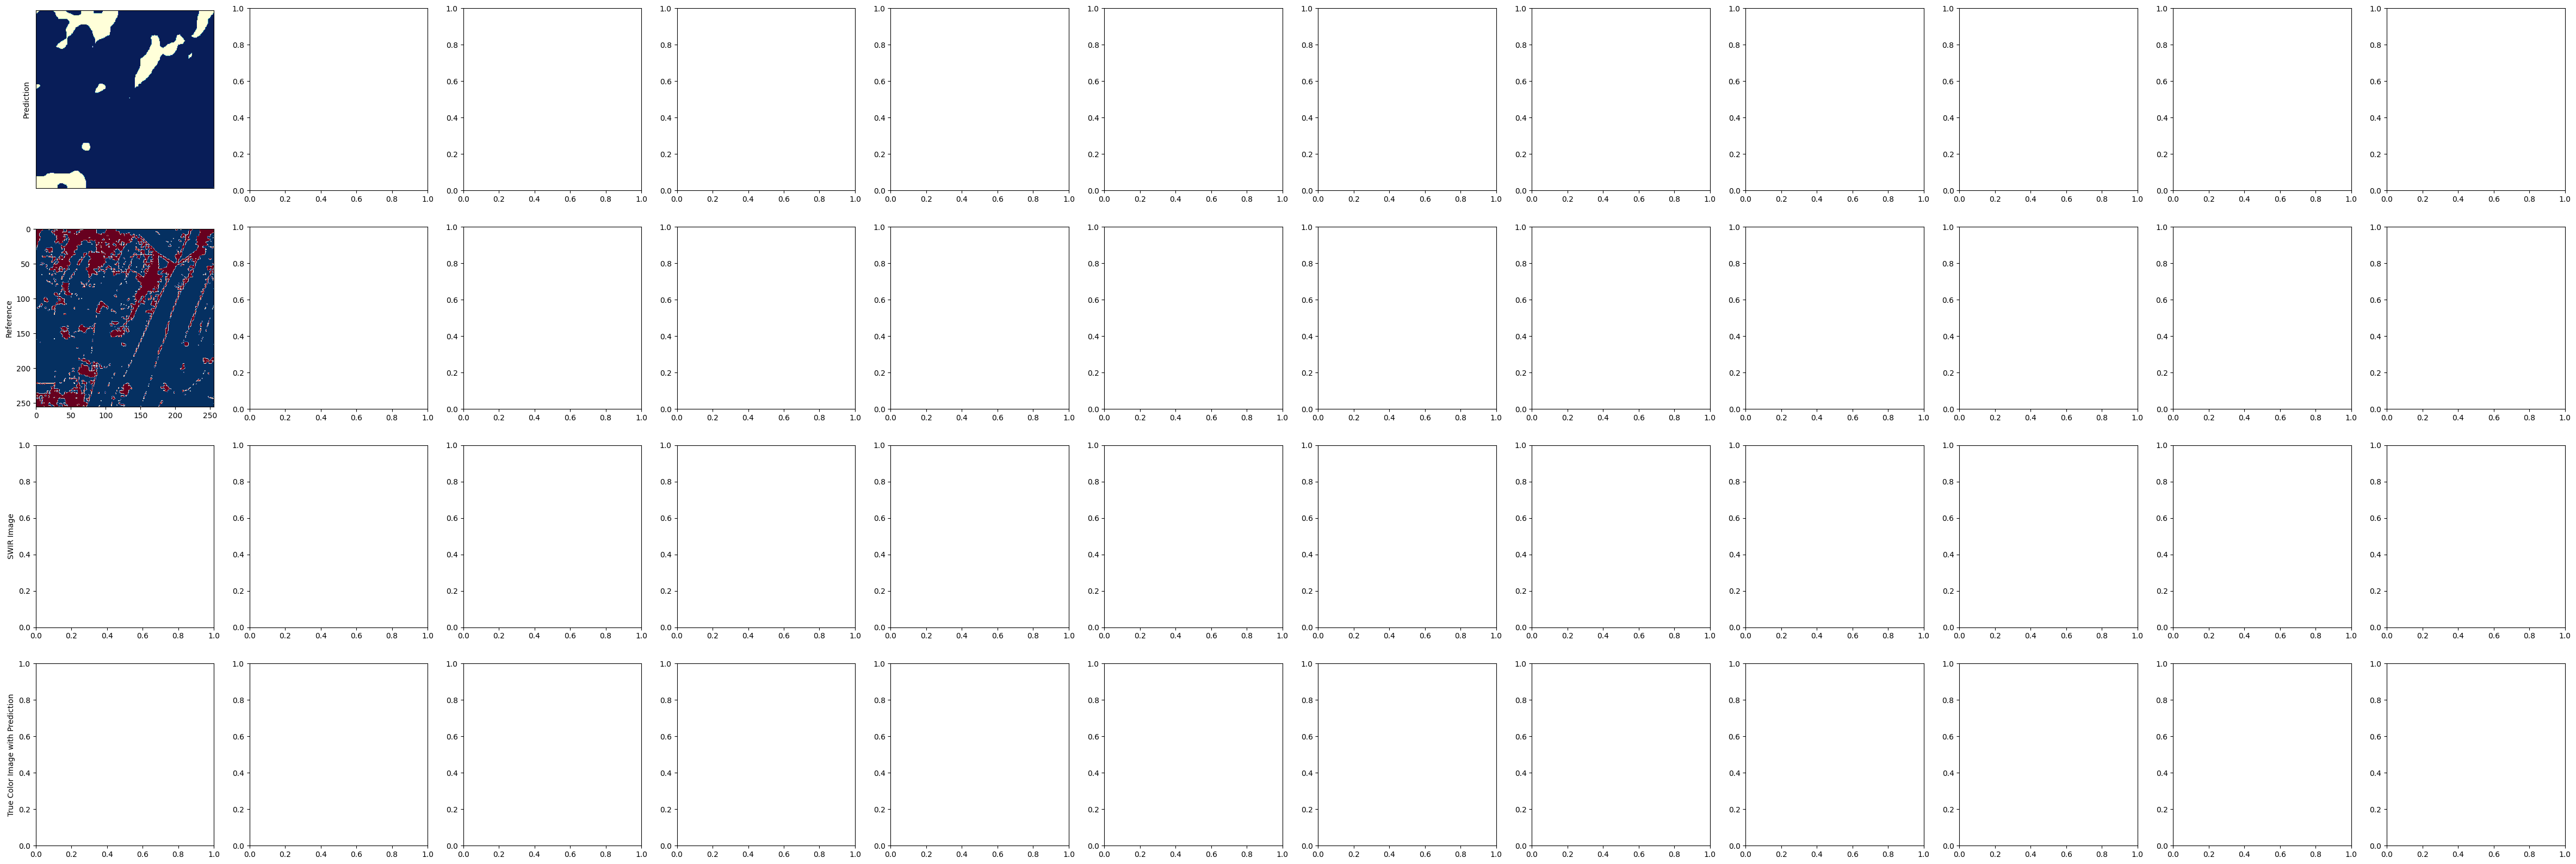

In [21]:
#%% testing loop
print('Start testing...')
model.eval()
losss_test = []
accs_test = []
weights_test = []
with torch.no_grad():              
    for step_test, (x_test, y_test, mask_test, idx_test) in enumerate(dataloader_test):
        print('Test step %i'%(step_test))

        #%%%% clean cache of GPU
        torch.cuda.empty_cache()

        #%%%% forward pass
        if type(x_test)==list:
            out_test = model.forward([item_.to(config["device"]) for item_ in x_test])
        else:
            out_test = model.forward(x_test.to(config["device"]))

        #%%%% compute loss
        loss_test = loss_function(out_test.softmax(1),y_test.squeeze(1).to(config["device"]))
        loss_test = (loss_test*mask_test.long().squeeze(1).to(config["device"])).sum() / (torch.count_nonzero(mask_test.long().to(config["device"])))

        #%%%% compute metric
        if type(metric)==list:
            test_acc = [metric_(out_test.cpu().detach(),y_test.cpu().detach(),mask_test.cpu().detach()) for metric_ in metric]
        else:
            test_acc = metric(out_test.cpu().detach(),y_test.cpu().detach(),mask_test.cpu().detach())

        #%%%% printing stuff
        print(
            "[{}] Test Step: {:d}/{:d}, \tbatch_size: {} \tLoss: {:.4f} \tAcc: {}".format(
                dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                step_test+1,
                len(dataloader_test),
                dataloader_test.batch_size,
                loss_test.mean(),
                {metric_.__name__:test_acc_ for metric_,test_acc_ in zip(metric,test_acc)} if type(metric)==list else test_acc
            )
        )

        #%%%% collect loss and accuracy
        losss_test.append(loss_test.cpu().detach().numpy())
        accs_test.append(test_acc)
        weights_test.append(torch.count_nonzero(mask_test).cpu().detach().numpy())
        
        #%%%% plot
        #%%%%% calculations for plot
        prediction_test = torch.argmax(out_test,1).cpu()
        eopatches = [EOPatch.load(dataset_test.paths[idx_.cpu()]) for idx_ in idx_test[0]]
        imgs_swir = [np.stack(
            (eopatch[(FeatureType.DATA_TIMELESS,"B11")].squeeze(-1),
             eopatch[(FeatureType.DATA_TIMELESS,"B08")].squeeze(-1),
             eopatch[(FeatureType.DATA_TIMELESS,"B04")].squeeze(-1)),
            axis = -1
        ) for eopatch in eopatches]
        imgs_true = [np.stack(
            (eopatch[(FeatureType.DATA_TIMELESS,"B04")].squeeze(-1),
             eopatch[(FeatureType.DATA_TIMELESS,"B03")].squeeze(-1),
             eopatch[(FeatureType.DATA_TIMELESS,"B02")].squeeze(-1)),
            axis = -1
        ) for eopatch in eopatches]
        
        #%%%%% batch plot
        fig, axis = plt.subplots(nrows=4, ncols=dataloader_test.batch_size, figsize=(5*dataloader_test.batch_size,5*4))
        axis[0][0].set_ylabel("Prediction")
        axis[1][0].set_ylabel("Reference")
        axis[2][0].set_ylabel("SWIR Image")
        axis[3][0].set_ylabel("True Color Image with Prediction")
        for i in range(dataloader_test.batch_size):
            axis[0][i].imshow(prediction_test[i],vmin=0,vmax=config["num_classes"]-1,cmap="YlGnBu")
            axis[0][i].set_yticks([])
            axis[0][i].set_xticks([])
            
            axis[1][i].imshow(y_test.squeeze(1)[i].cpu(),vmin=0,vmax=config["num_classes"]-1,cmap="RdBu")
            axis[1][i].imshow(mask_test.squeeze(1)[i].cpu(),vmin=0,vmax=1,cmap=cmap_alpha("Wistia_r",ncolors=190,alpharange=[0.6,0]))
            axis[1][i].set_yticks([])
            axis[1][i].set_xticks([])
            
            axis[2][i].imshow(imgs_swir[i]/np.max(imgs_swir[i]),vmin=0,vmax=config["num_classes"]-1,cmap="RdBu")
            axis[2][i].set_yticks([])
            axis[2][i].set_xticks([])
            
            axis[3][i].imshow(imgs_true[i]/np.max(imgs_true[i]),vmin=0,vmax=config["num_classes"]-1,cmap="RdBu")
            axis[3][i].imshow(torch.argmax(out_test,1)[i].cpu(),vmin=0,vmax=config["num_classes"]-1,cmap=cmap_alpha("Blues",ncolors=189,alpharange=[0,0.3]))
            axis[3][i].set_yticks([])
            axis[3][i].set_xticks([])
        plt.subplots_adjust(left=0, bottom=0.05, right=1, top=0.95, wspace=0.1, hspace=0)
        plt.show()

    #%%%% total loss and accuracy
    total = np.sum([np.sum(weight_) for weight_ in weights_test])
    loss_test_total = np.sum([weight_/total*loss_ for weight_,loss_ in zip(weights_test,losss_test)])
    if type(metric)==list:
        acc_test_total = [np.sum([weight_/total*acc_[i] for weight_,acc_ in zip(weights_test,accs_test)]) for i in range(len(metric))]
    else:
        acc_test_total = np.sum([weight_/total*acc_ for weight_,acc_ in zip(weights_test,accs_test)])

    # print total values
    print(
        "[{}] Test: \tTotal Loss: {:.4f} \tTotal Acc: {}".format(
            dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
            loss_test_total,
            {metric_.__name__:test_acc_ for metric_,test_acc_ in zip(metric,acc_test_total)} if type(metric)==list else acc_test_total
        )
    )

    #%%% write to tensorboard
    #%%%% log loss
    writer.add_scalar(f'LossTest/{type(loss_function).__name__}', loss_test_total, global_step=step_test)

    #%%%% log metric
    if type(metric)==list:
        writer.add_scalars('AccuracyTest',{metric_.__name__:test_acc_ for metric_,test_acc_ in zip(metric,acc_test_total)},global_step=step_test)
    else:
        writer.add_scalar('AccuracyTest', acc_test_total, global_step=step_test)
print()

Our model has been trained and tested.
Hence, we free our GPU from it and it's corresponding variables.

In [ ]:
del(model)
del(optimizer)
del(x)
del(y)
del(mask)
del(x_validation)
del(y_validation)
del(mask_validation)
del(x_test)
del(y_test)
del(mask_test)
del(loss)
del(loss_validation)
del(loss_test)
del(grad)
torch.cuda.empty_cache()

# Evaluation
Finally and after a long time doing training, validation and testing, we may have a look at the tensorboard.
Please make sure, that the tensorboard is running!

In [ ]:
notebook.list()
print('\nPlease check, if the port is correct and tensorboard is running!\n')
notebook.display(port=6006,height=1000)